In [3]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from tabulate import tabulate
import functools

## define function for printing pandas dataframes as markdown (in case it is needed)

In [4]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [5]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## helper fuction for showing values on bars
adapted from: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

In [6]:
def show_values_on_bars(axs, h_v="v", horizontal_space=5, vertical_space=5, ha="center", va="bottom", fontsize=12):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(vertical_space)
                # print(p.get_height())
                value = int(p.get_height())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(horizontal_space)
                # print(p.get_width())
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## load saved data

In [7]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [8]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

# Plot data

## plot get patient counts by gender

In [9]:
gender_count = patient_df.gender.value_counts()
gender_count.loc['total'] = len(patient_df)
gender_count

female    121855
male       95047
total     216902
Name: gender, dtype: int64

In [10]:
# print_pandas_md(pds.DataFrame(gender_count)) # in case I need the table in markdown

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


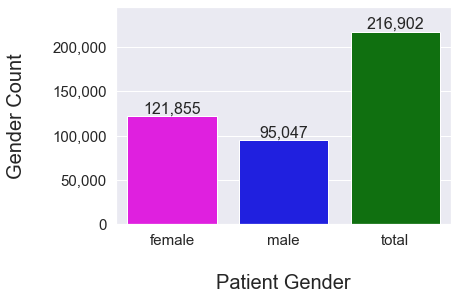

In [32]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue', 'green']
sns.set_palette(colors)

# plot gender counts
ax = sns.barplot(x=gender_count.index, y=gender_count.values)
ax.set_xlabel("\nPatient Gender", size=20)
ax.set_ylabel("Gender Count\n", size=20)
plt.xticks(size=15)
plt.yticks(size=15)

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 245000)

plt.savefig("figures/patient-gender-counts.png", dpi=600, bbox_inches="tight")
plt.show()

## calculate age distributions and plot

In [12]:
## define bins for historgrams
age_bins = \
    pds.IntervalIndex.from_arrays([0, 12, 23, 34, 45, 56, 68, 79, 90, 101], [12, 23, 34, 45, 56, 68, 79, 90, 101, 112])
age_bins

IntervalIndex([(0, 12], (12, 23], (23, 34], (34, 45], (45, 56], (56, 68], (68, 79], (79, 90], (90, 101], (101, 112]],
              closed='right',
              dtype='interval[int64]')

In [13]:
age_table = \
    pds.DataFrame(pds.cut(patient_df['patient_age'], age_bins).value_counts().sort_index()).reset_index()
age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
# age_table['Age Range'] = age_table['Age Range'].map(lambda x: round_interval(x))
age_table['Percent'] = round((age_table['Total'] / 216902) * 100, 1)
age_table.to_clipboard()
age_table

,Age Range,Total,Percent
0,"(0, 12]",4351,2.0
1,"(12, 23]",30148,13.9
2,"(23, 34]",42427,19.6
3,"(34, 45]",42034,19.4
4,"(45, 56]",39219,18.1
5,"(56, 68]",35100,16.2
6,"(68, 79]",15712,7.2
7,"(79, 90]",6645,3.1
8,"(90, 101]",1197,0.6
9,"(101, 112]",69,0.0


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.


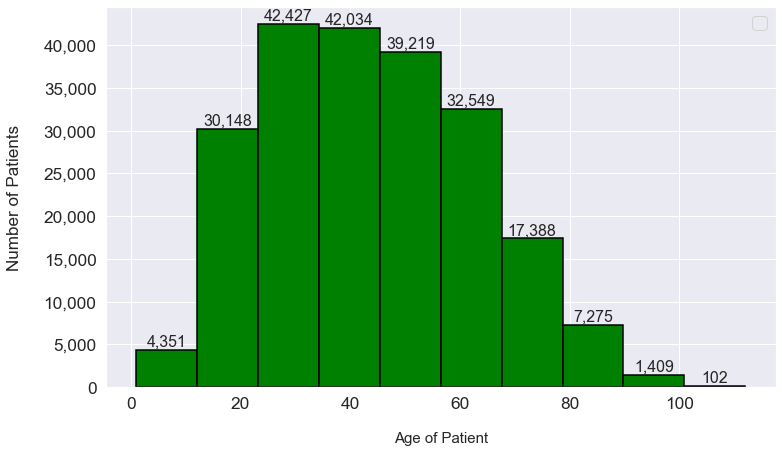

In [40]:
%matplotlib inline
sns.set()

# plot age distribution
ax = patient_df['patient_age']\
        .hist(bins=10, color='green', edgecolor='black', linewidth=1.5,figsize=(12,7))

ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 44500)

plt.legend(loc='upper right', prop={'size': 18})
# plt.savefig("figures/patient-age-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

### calculate female age intervals

In [15]:
females = patient_df.query("gender == 'female'")['patient_age']
female_age_table = \
    pds.DataFrame(pds.cut(females, age_bins).value_counts().sort_index()).reset_index()
female_age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
female_age_table['Age Range'] = female_age_table['Age Range'].map(lambda x: round_interval(x))
female_age_table['Percent Female'] = round((female_age_table['Total'] / 226798) * 100, 1)
# print_pandas_md(female_age_table)
female_age_table.to_clipboard()
female_age_table

,Age Range,Total,Percent Female
0,"[0, 12)",2348,1.0
1,"[12, 23)",15852,7.0
2,"[23, 34)",24587,10.8
3,"[34, 45)",24472,10.8
4,"[45, 56)",22261,9.8
5,"[56, 68)",19563,8.6
6,"[68, 79)",8321,3.7
7,"[79, 90)",3656,1.6
8,"[90, 101)",749,0.3
9,"[101, 112)",46,0.0


### calculate male age intervals

In [13]:
males = patient_df.query("gender == 'male'")['patient_age']
male_age_table = \
    pds.DataFrame(pds.cut(males, age_bins).value_counts().sort_index()).reset_index()
male_age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
male_age_table['Age Range'] = male_age_table['Age Range'].map(lambda x: round_interval(x))
male_age_table['Percent Male'] = round((male_age_table['Total'] / 226798) * 100, 1)
# print_pandas_md(male_age_table)
male_age_table.to_clipboard()
male_age_table

,Age Range,Total,Percent Male
0,"[0, 12)",2003,0.9
1,"[12, 23)",14296,6.3
2,"[23, 34)",17840,7.9
3,"[34, 45)",17562,7.7
4,"[45, 56)",16958,7.5
5,"[56, 68)",15537,6.9
6,"[68, 79)",7391,3.3
7,"[79, 90)",2989,1.3
8,"[90, 101)",448,0.2
9,"[101, 112)",23,0.0


### plot female/male age distribution

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


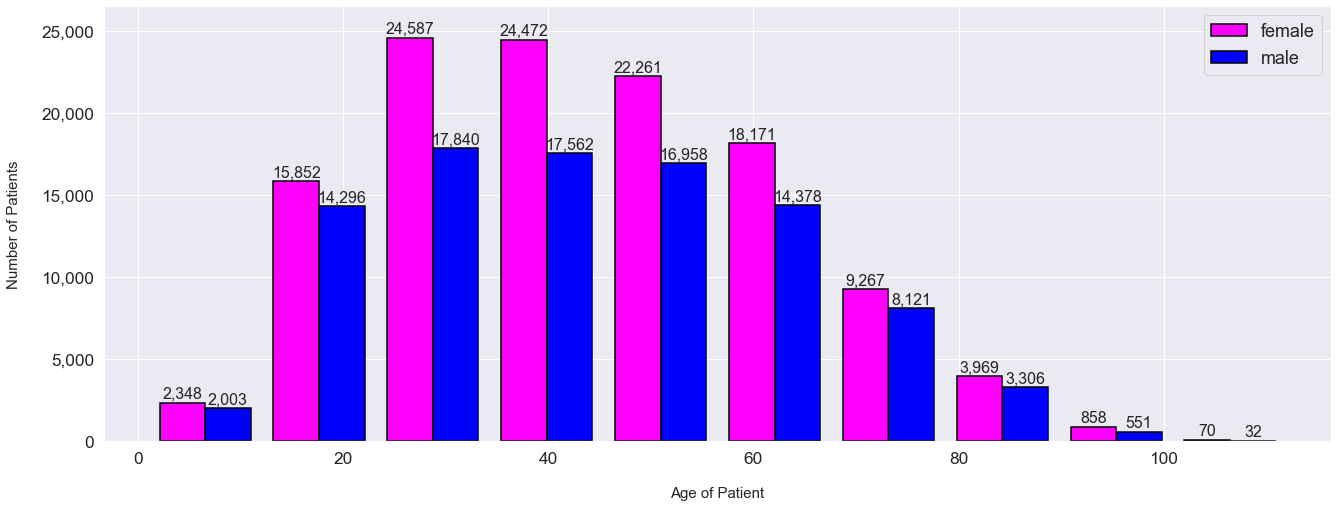

In [27]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue']
sns.set_palette(colors)

# create separate series for genders
females = patient_df.query("gender == 'female'")['patient_age']
males = patient_df.query("gender == 'male'")['patient_age']

fig, ax = plt.subplots(figsize=(22,8)) 
ax.hist([females, males], bins=10, edgecolor='black', linewidth=1.5, label=['female', 'male'])
ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=15)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 26500)

# plt.figure(figsize=(12,7))
plt.legend(loc='upper right', prop={'size': 18})
plt.savefig("figures/patient-age-gender-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize the number of patients (that had a procedure) over time

### merge patient info with procedure date info

In [16]:
patient_proc_date_df = \
    pds.merge(patient_df, tooth_proc_df[['patient_id', 'event_date']], how='inner', on='patient_id').drop_duplicates()

In [17]:
# patient_proc_date_df.head()

### add year of procedure

In [18]:
patient_proc_date_df.event_date = pds.to_datetime(patient_proc_date_df.event_date) # convert to datetime
patient_proc_date_df['event_year'] = pds.DatetimeIndex(patient_proc_date_df.event_date).year # get just the year
patient_proc_date_df.drop_duplicates(inplace=True) # remove any duplicates

In [19]:
# patient_proc_date_df.head()

### drop any year beyond 2015

In [20]:
patient_proc_date_df = patient_proc_date_df[patient_proc_date_df.event_year < 2016]

### calculate yearly totals

In [21]:
patient_proc_date_count_df = \
    pds.DataFrame(patient_proc_date_df.groupby('event_year')['event_year'].count()).rename(columns={'event_year': 'total'}).reset_index()

In [22]:
patient_proc_date_count_df[(patient_proc_date_count_df.event_year > 1998) & (patient_proc_date_count_df.event_year < 2016)]

,event_year,total
20,1999,13244
21,2000,18664
22,2001,25313
23,2002,32945
24,2003,43502
25,2004,48940
26,2005,52295
27,2006,51952
28,2007,54776
29,2008,58316


### plot

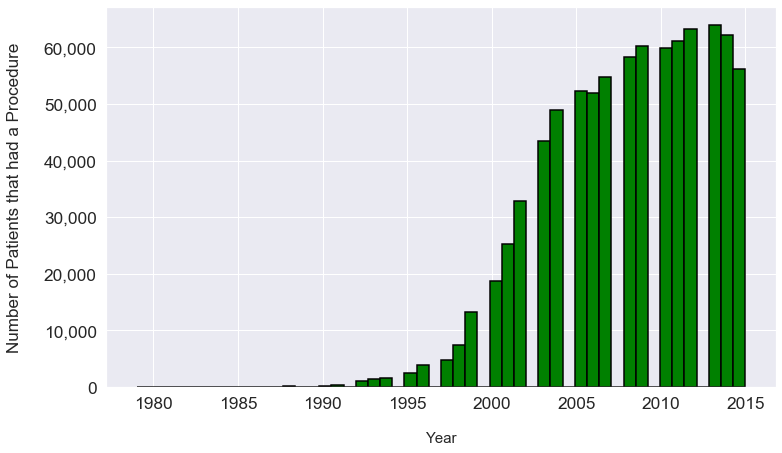

In [23]:
%matplotlib inline
sns.set()

# plot age distribution
ax = patient_proc_date_df['event_year']\
        .hist(bins=50, color='green', edgecolor='black', linewidth=1.5,figsize=(12,7))

ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.savefig("figures/patient-count-by-year-hist.png", dpi=600, bbox_inches="tight")
plt.show()

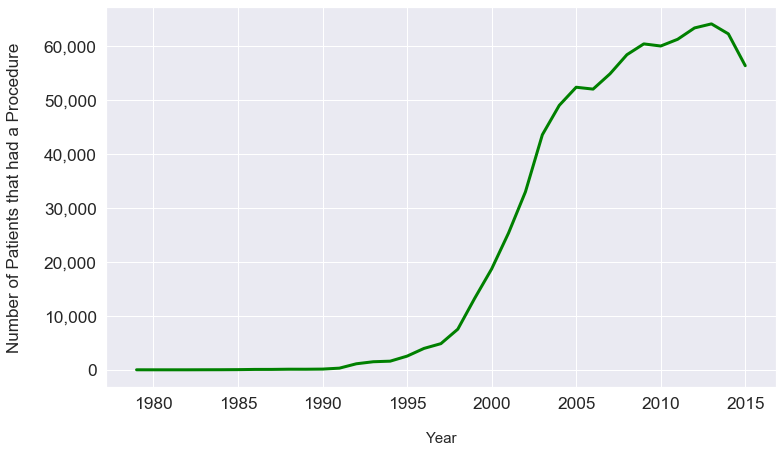

In [24]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=patient_proc_date_count_df, color="green")

ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("figures/patient-count-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize the number of patients (that had a procedure) over time by gender

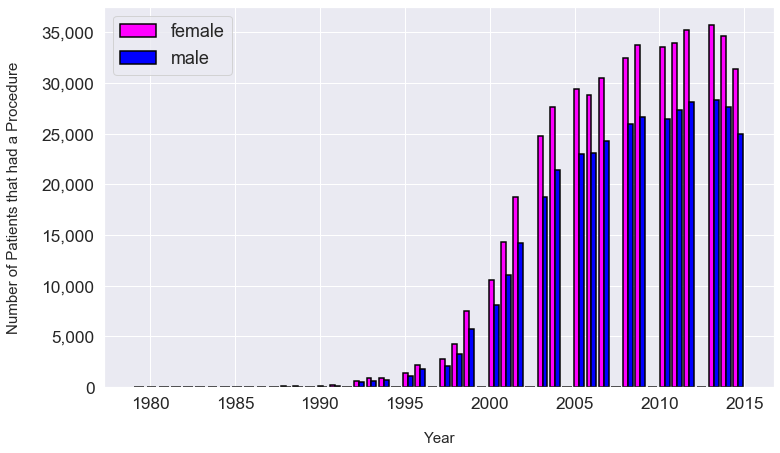

In [25]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue']
sns.set_palette(colors)

# create separate series for genders
females_year = patient_proc_date_df.query("gender == 'female'")['event_year']
males_year = patient_proc_date_df.query("gender == 'male'")['event_year']

fig, ax = plt.subplots(figsize=(12,7)) 
ax.hist([females_year, males_year], bins=50, edgecolor='black', linewidth=1.5, label=['female', 'male'])
ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=15)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', prop={'size': 18})
plt.savefig("figures/patient-count-by-year-and-gender-bar.png", dpi=600, bbox_inches="tight")
plt.show()

In [26]:
patient_gender_proc_date_count_df = \
    pds.DataFrame(patient_proc_date_df.groupby(['event_year', 'gender'])['event_year'].count()).rename(columns={'event_year': 'total'}).reset_index()
patient_gender_proc_date_count_df.sort_values(by='gender', inplace=True)

In [27]:
# patient_gender_proc_date_count_df

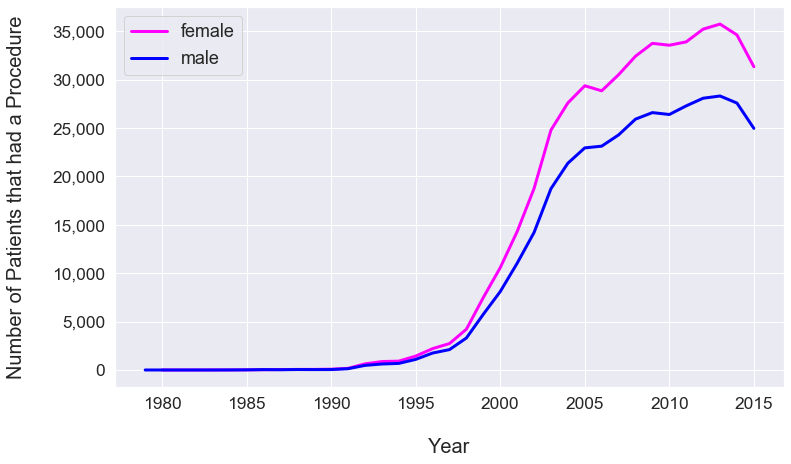

In [29]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=patient_gender_proc_date_count_df, hue="gender", legend=False)

ax.set_xlabel("\nYear", fontsize=20)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=20)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', labels=['female', 'male'], prop={'size': 18})
plt.savefig("figures/patient-count-by-year-and-gender-line.png", dpi=600, bbox_inches="tight")
plt.show()